In [41]:
# Tunisian Olive Oil Price Forecasting using Time Series Analysis
#
# This notebook analyzes historical olive oil prices and develops a forecasting model
# to predict local Tunisian prices for 2025

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from google.colab import files
uploaded = files.upload()

# For time series forecasting
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("coolwarm")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12


Saving olive.csv to olive (2).csv


In [42]:
# ## 1. Data Loading and Preparation
# Load the CSV data
df = pd.read_csv('olive.csv', sep=';')

# Display the first few rows of the dataset
print("Dataset overview:")
display(df.head())

# Check dataset info
print("\nDataset information:")
print(f"Shape: {df.shape}")
display(df.dtypes)

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Handle the issue with the misidentified Tunisian price column
# We'll rename it to clarify that it's actually global price converted to TND
df = df.rename(columns={'Tunisian_Price_TND_per_liter': 'Global_Price_TND_per_liter'})

# Create a new column to estimate actual Tunisian local prices
# Based on research reports, local prices typically follow global prices but with adjustments
# For example, reports suggest a differential based on local market conditions
# We'll use the additional price data provided to establish a relationship

Dataset overview:


,Date,Global_Price_USD_per_tonne,Global_Price_TND_per_liter,Yearly_production(1000Tonne),Yearly_Exports,Yearly_Imports
0,31/01/2015,4128.513119,6.806862,1700.0,7.684995e+09,1658898.0
1,28/02/2015,4169.564192,6.874545,1700.0,7.684995e+09,1658898.0
2,31/03/2015,3933.601822,6.485503,1700.0,7.684995e+09,1658898.0
3,30/04/2015,3996.582960,6.589343,1700.0,7.684995e+09,1658898.0
4,31/05/2015,4305.325946,7.098381,1700.0,7.684995e+09,1658898.0



Dataset information:
Shape: (108, 6)


,0
Date,object
Global_Price_USD_per_tonne,float64
Global_Price_TND_per_liter,float64
Yearly_production(1000Tonne),float64
Yearly_Exports,float64
Yearly_Imports,float64



Missing values:


,0
Date,0
Global_Price_USD_per_tonne,0
Global_Price_TND_per_liter,0
Yearly_production(1000Tonne),0
Yearly_Exports,0
Yearly_Imports,0


In [43]:
# ## 2. Integrating Additional Data

# Create production and consumption dataset
production_consumption = pd.DataFrame({
    'Year': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Tunisia_Production_Min': [110, 120, 100, 220, 280, 320, 100, 100, 240, 120, 340, 140, 180, 200, 220],
    'Tunisia_Production_Max': [140, np.nan, 140, 260, 330, 350, 140, 140, 300, 350, 440, np.nan, 340, 217, np.nan],
    'Tunisia_Consumption': [80, np.nan, np.nan, 35, 30, np.nan, np.nan, 35, np.nan, 33.6, np.nan, np.nan, np.nan, np.nan, np.nan],
    'Italy_Production_Min': [548, 477, np.nan, 273, 450, 300, 182, 429, 270, 365, 250, 270, 329, 240, 300],
    'Italy_Production_Max': [np.nan, 500, np.nan, 415.5, 500, 343, 243, 486, np.nan, np.nan, 365, 279.5, np.nan, 288.9, 328.5],
    'Italy_Consumption': [660, 660, np.nan, 590, 695, np.nan, np.nan, np.nan, 557, 589, 408, 419, 482, 486, np.nan],
    'Spain_Production_Min': [1370, np.nan, 1420, 820, 1360, 1260, np.nan, np.nan, 1350, np.nan, 1380, 1150, 666, 660, 760],
    'Spain_Production_Max': [1400, np.nan, 1480, 1520, 1580, 1400, 1280, 1250, np.nan, np.nan, 1400, 1490, 1600, 850, 850],
    'Spain_Consumption': [550, np.nan, np.nan, 425, np.nan, np.nan, np.nan, np.nan, np.nan, 604, 541, 521, np.nan, 363, 402]
})

# Create price dataset
price_data = {
'Year': [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
'Local_Price': ['3,6/L', '4,5-5,5/L', '6-6,5/L', '5,5-6/L', '8/L', '9/L', '8,8/L', '5,6/L',
'10-12/L', '10-12/L', '10-12/L', '15/L', '15-17/L', '18-22/L']
}

local_prices = pd.DataFrame(price_data)

In [44]:
# Function to split price range and convert to float
def process_price(price_str):
    price_str = price_str.replace('/L', '').replace(',', '.')
    if '-' in price_str:
        parts = price_str.split('-')
        return float(parts[0]), float(parts[1])
    else:
        val = float(price_str)
        return val, val

# Create min/max columns
local_prices[['Tunisia_Local_Price_Min', 'Tunisia_Local_Price_Max']] = local_prices['Local_Price'].apply(
    lambda x: pd.Series(process_price(x)))


local_prices = local_prices.drop('Local_Price', axis=1)


df = df.merge(local_prices, on='Year', how='left')

print("\nProcessed local prices:")
display(local_prices)


Processed local prices:


,Year,Tunisia_Local_Price_Min,Tunisia_Local_Price_Max
0,2012,3.6,3.6
1,2013,4.5,5.5
2,2014,6.0,6.5
3,2015,5.5,6.0
4,2016,8.0,8.0
5,2017,9.0,9.0
6,2018,8.8,8.8
7,2019,5.6,5.6
8,2020,10.0,12.0
9,2021,10.0,12.0


In [46]:
# ## 3. Local Price Estimation


df = df.merge(local_prices, on='Year', how='left')

def estimate_local_price(row):

    if pd.notna(row['Tunisia_Local_Price_Min']):
        return np.random.uniform(row['Tunisia_Local_Price_Min'], row['Tunisia_Local_Price_Max'])

    year = row['Year']
    global_price = row['Global_Price_TND_per_liter']

    if year <= 2018:
        return global_price * np.random.uniform(0.8, 1.2)
    elif year <= 2021:
        return global_price * np.random.uniform(0.9, 1.4)
    else:
        return global_price * np.random.uniform(1.1, 1.6)


np.random.seed(42)
df['Estimated_Local_Price_TND_per_liter'] = df.apply(estimate_local_price, axis=1)

# Temporal smoothing adjusted for official data presence
for year in df['Year'].unique():
    year_mask = df['Year'] == year
    if pd.notna(df.loc[year_mask, 'Tunisia_Local_Price_Min']).any():
        # Use official price range as anchor
        avg_price = df.loc[year_mask, ['Tunisia_Local_Price_Min', 'Tunisia_Local_Price_Max']].mean(axis=1)
        df.loc[year_mask, 'Estimated_Local_Price_TND_per_liter'] = avg_price
    else:
        # Apply mild temporal smoothing
        year_avg = df.loc[year_mask, 'Estimated_Local_Price_TND_per_liter'].mean()
        df.loc[year_mask, 'Estimated_Local_Price_TND_per_liter'] = \
            df.loc[year_mask, 'Estimated_Local_Price_TND_per_liter'].fillna(year_avg)

print("\nRestored Price Estimation with Official Data Integration:")
display(df[['Date', 'Global_Price_TND_per_liter',
            'Tunisia_Local_Price_Min', 'Tunisia_Local_Price_Max',
            'Estimated_Local_Price_TND_per_liter']].head(10))


Restored Price Estimation with Official Data Integration:


,Date,Global_Price_TND_per_liter,Tunisia_Local_Price_Min,Tunisia_Local_Price_Max,Estimated_Local_Price_TND_per_liter
0,2015-01-31,6.806862,5.5,6.0,5.75
1,2015-02-28,6.874545,5.5,6.0,5.75
2,2015-03-31,6.485503,5.5,6.0,5.75
3,2015-04-30,6.589343,5.5,6.0,5.75
4,2015-05-31,7.098381,5.5,6.0,5.75
5,2015-06-30,7.167583,5.5,6.0,5.75
6,2015-07-31,7.399101,5.5,6.0,5.75
7,2015-08-31,8.319228,5.5,6.0,5.75
8,2015-09-30,8.222080,5.5,6.0,5.75
9,2015-10-31,7.492711,5.5,6.0,5.75


In [47]:
# ## 3. Data Integration and Feature Engineering

# Create a yearly dataset from the monthly data
yearly_data = df.groupby('Year').agg({
    'Global_Price_USD_per_tonne': 'mean',
    'Global_Price_TND_per_liter': 'mean',
    'Estimated_Local_Price_TND_per_liter': 'mean',
    'Yearly_production(1000Tonne)': 'first',
    'Yearly_Exports': 'first',
    'Yearly_Imports': 'first'
}).reset_index()

# Merge with production and consumption data
combined_data = pd.merge(yearly_data, production_consumption, on='Year', how='outer')

# Fill missing consumption values using insights from reports (15-20% of production)
def estimate_consumption(row):
    if pd.isna(row['Tunisia_Consumption']):
        if not pd.isna(row['Tunisia_Production_Min']):
            return row['Tunisia_Production_Min'] * 0.18  # Based on report analysis
        elif not pd.isna(row['Yearly_production(1000Tonne)']):
            return row['Yearly_production(1000Tonne)'] * 0.18
    return row['Tunisia_Consumption']

combined_data['Tunisia_Consumption'] = combined_data.apply(estimate_consumption, axis=1)

# Calculate surplus/deficit and market tension metrics
combined_data['Tunisia_Surplus'] = combined_data['Tunisia_Production_Min'].fillna(combined_data['Yearly_production(1000Tonne)']) - combined_data['Tunisia_Consumption']
combined_data['Italy_Deficit'] = combined_data['Italy_Consumption'] - combined_data['Italy_Production_Min']
combined_data['Spain_Deficit'] = combined_data['Spain_Consumption'] - combined_data['Spain_Production_Min']

# Calculate EU import demand (Italy + Spain deficit)
combined_data['EU_Import_Demand'] = combined_data['Italy_Deficit'].fillna(0) + combined_data['Spain_Deficit'].fillna(0)

# Calculate market tension (ratio of import demand to export potential)
combined_data['Market_Tension'] = combined_data['EU_Import_Demand'] / combined_data['Tunisia_Surplus']
combined_data['Market_Tension'].replace([np.inf, -np.inf], np.nan, inplace=True)
combined_data['Market_Tension'].fillna(combined_data['Market_Tension'].median(), inplace=True)

# Create export ratio feature (original version)
combined_data['Export_Ratio'] = combined_data['Yearly_Exports'] / (combined_data['Tunisia_Production_Min'] * 1000000)
combined_data['Export_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
combined_data['Export_Ratio'].fillna(combined_data['Export_Ratio'].median(), inplace=True)

# Add price premium feature (local price premium over global price)
combined_data['Local_Price_Premium'] = combined_data['Estimated_Local_Price_TND_per_liter'] / combined_data['Global_Price_TND_per_liter']

# Add domestic market pressure (original version)
combined_data['Domestic_Market_Pressure'] = 1 / (combined_data['Tunisia_Surplus'] + 0.1)  # Add small constant to avoid div by zero


print("\nEnriched Dataset with Market Features:")
display(combined_data.iloc[5:14])



Enriched Dataset with Market Features:


,Year,Global_Price_USD_per_tonne,Global_Price_TND_per_liter,Estimated_Local_Price_TND_per_liter,Yearly_production(1000Tonne),Yearly_Exports,Yearly_Imports,Tunisia_Production_Min,Tunisia_Production_Max,Tunisia_Consumption,...,Spain_Production_Max,Spain_Consumption,Tunisia_Surplus,Italy_Deficit,Spain_Deficit,EU_Import_Demand,Market_Tension,Export_Ratio,Local_Price_Premium,Domestic_Market_Pressure
5,2015,4292.834858,7.077787,5.75,1700.0,7.684995e+09,1658898.0,320,350.0,57.6,...,1400.0,NaN,262.4,NaN,NaN,0.0,0.000000,24.015611,0.812401,0.003810
6,2016,3978.466263,7.288304,8.00,700.0,7.685666e+09,12978872.0,100,140.0,18.0,...,1280.0,NaN,82.0,NaN,NaN,0.0,0.000000,76.856657,1.097649,0.012180
7,2017,4529.796772,8.713222,9.00,500.0,8.437997e+09,6589306.0,100,140.0,35.0,...,1250.0,NaN,65.0,NaN,NaN,0.0,0.000000,84.379970,1.032913,0.015361
8,2018,3911.728989,7.882650,8.80,1617.0,8.720386e+09,1730654.0,240,300.0,43.2,...,NaN,NaN,196.8,287.0,NaN,287.0,1.458333,36.334941,1.116376,0.005079
9,2019,3166.333453,6.670606,5.60,700.0,7.378382e+09,2751791.0,120,350.0,33.6,...,NaN,604.0,86.4,224.0,NaN,224.0,2.592593,61.486513,0.839504,0.011561
10,2020,2628.342039,5.777952,11.00,2000.0,7.917069e+09,1245341.0,340,440.0,61.2,...,1400.0,541.0,278.8,158.0,-839.0,-681.0,-2.442611,23.285498,1.903789,0.003586
11,2021,4184.763091,9.582783,11.00,700.0,8.821532e+09,1538275.0,140,NaN,25.2,...,1490.0,521.0,114.8,149.0,-629.0,-480.0,-4.181185,63.010943,1.147892,0.008703
12,2022,4469.885163,10.645118,11.00,1200.0,1.031655e+10,1169022.0,180,340.0,32.4,...,1600.0,NaN,147.6,153.0,NaN,153.0,1.036585,57.314154,1.033338,0.006770
13,2023,7709.617522,19.066781,15.00,700.0,1.187855e+10,4752652.0,200,217.0,36.0,...,850.0,363.0,164.0,246.0,-297.0,-51.0,-0.310976,59.392770,0.786709,0.006094


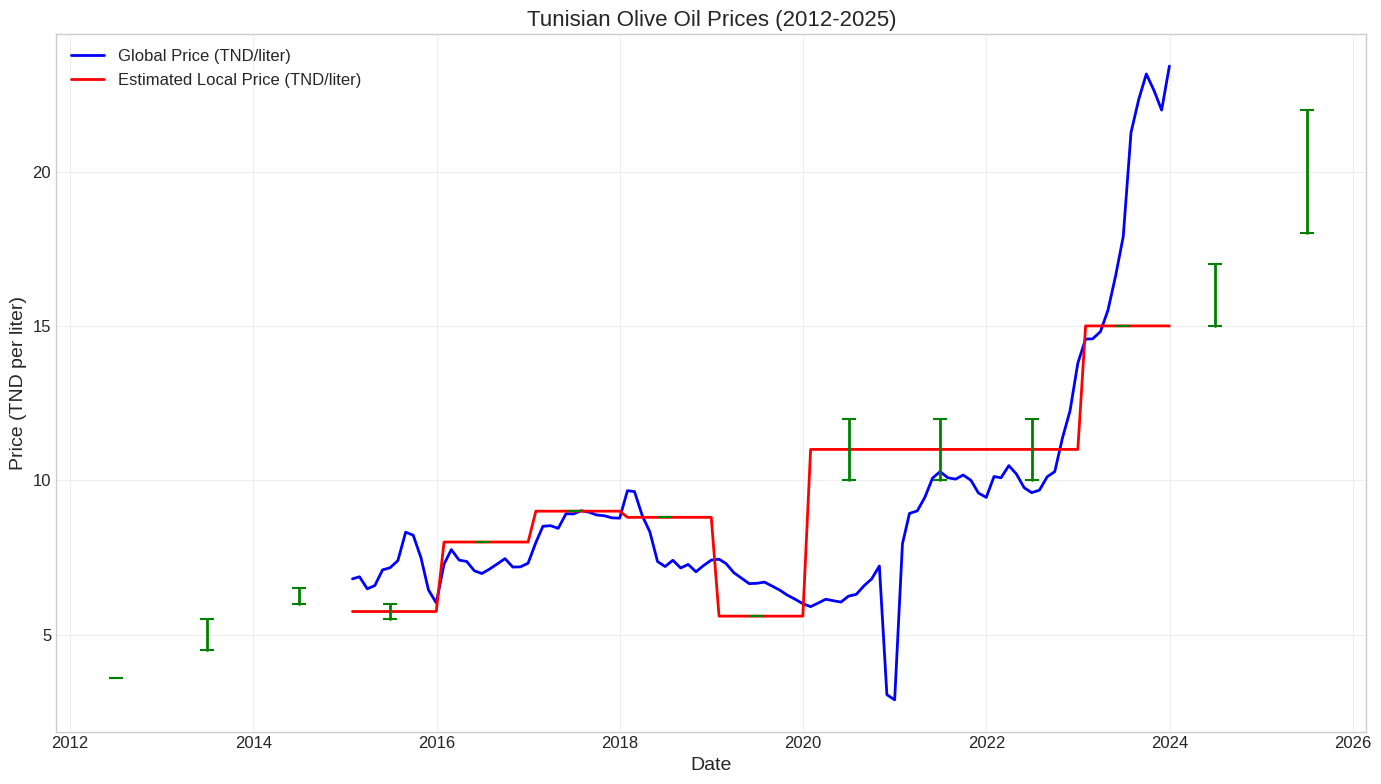

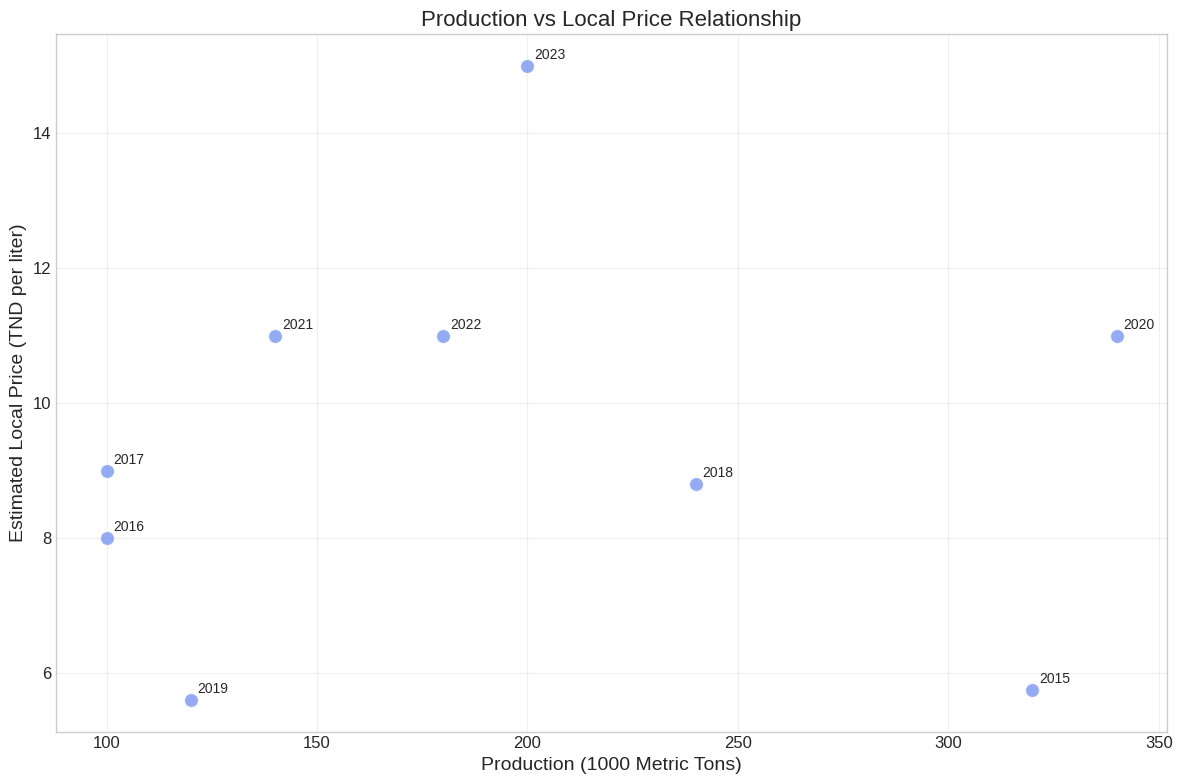

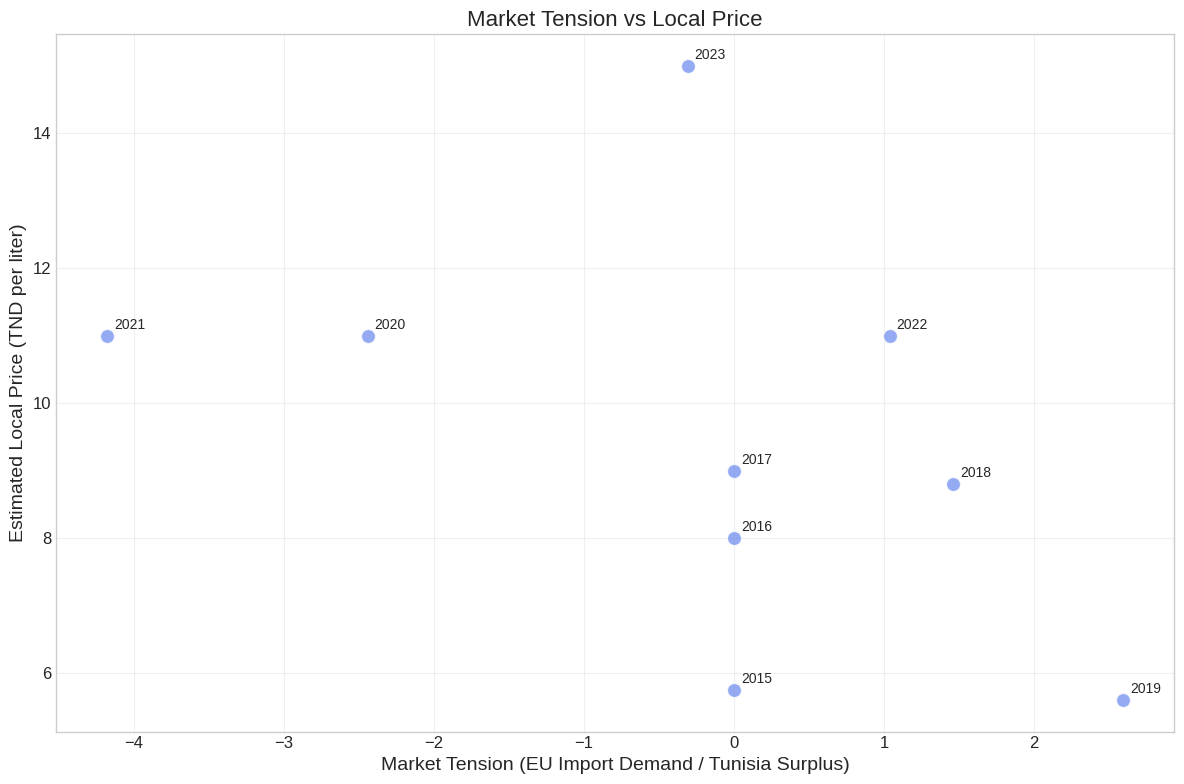

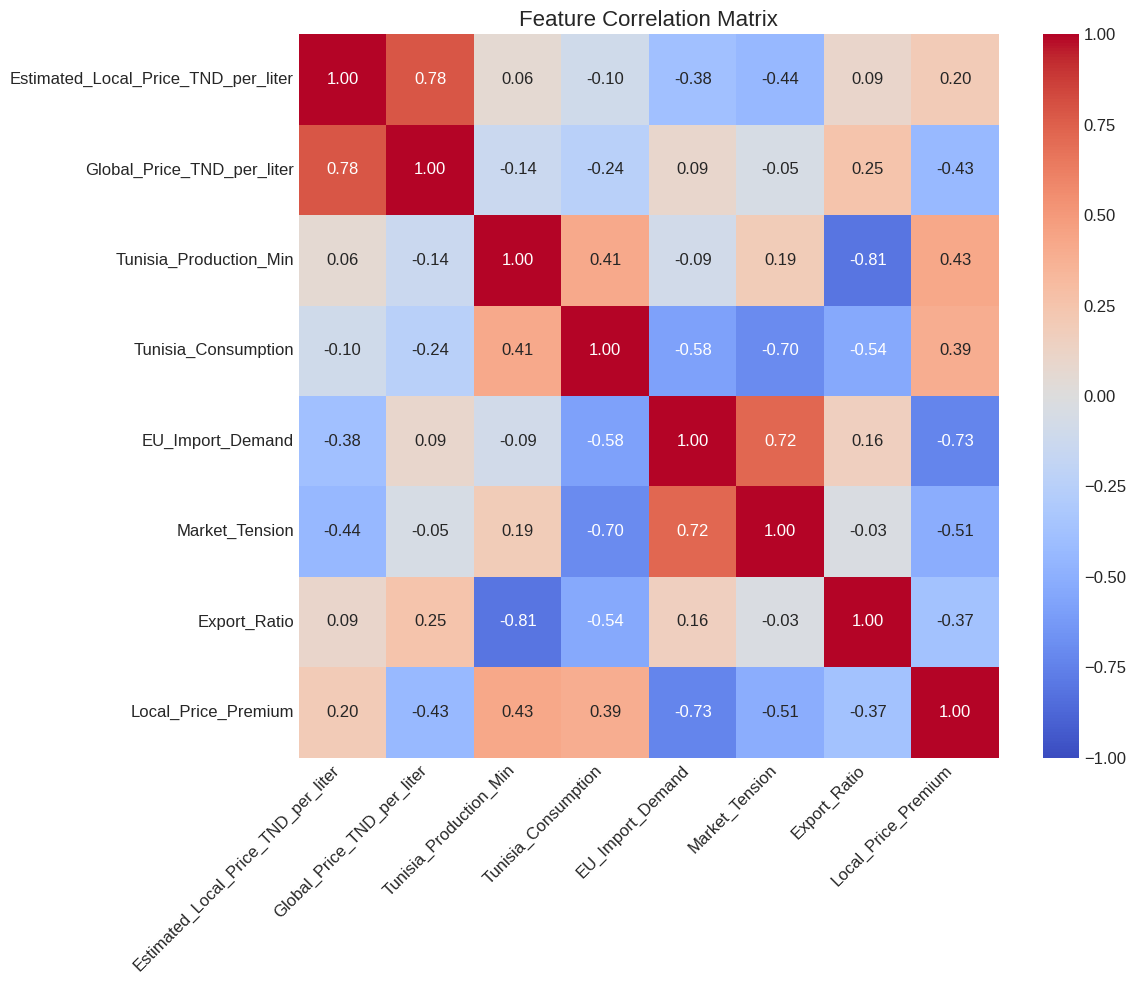

In [48]:
# ## 4. Exploratory Data Analysis

# Plot historical price trends using available data
plt.figure(figsize=(14, 8))
plt.plot(df['Date'], df['Global_Price_TND_per_liter'], 'b-', linewidth=2, label='Global Price (TND/liter)')
plt.plot(df['Date'], df['Estimated_Local_Price_TND_per_liter'], 'r-', linewidth=2, label='Estimated Local Price (TND/liter)')


for _, row in local_prices.iterrows():
    year_date = pd.to_datetime(f"{int(row['Year'])}-07-01")  # Mid-year reference
    if not pd.isna(row['Tunisia_Local_Price_Min']):
        plt.scatter(year_date, row['Tunisia_Local_Price_Min'], color='green', s=100, zorder=5, marker='_')
        plt.scatter(year_date, row['Tunisia_Local_Price_Max'], color='green', s=100, zorder=5, marker='_') #Fixed indentation here
        plt.plot([year_date, year_date],
                 [row['Tunisia_Local_Price_Min'], row['Tunisia_Local_Price_Max']],
                 color='green', linewidth=2)

plt.title('Tunisian Olive Oil Prices (2012-2025)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (TND per liter)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot production vs price relationship
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Tunisia_Production_Min', y='Estimated_Local_Price_TND_per_liter',
                data=combined_data, s=100, alpha=0.7)
plt.title('Production vs Local Price Relationship', fontsize=16)
plt.xlabel('Production (1000 Metric Tons)', fontsize=14)
plt.ylabel('Estimated Local Price (TND per liter)', fontsize=14)
plt.grid(True, alpha=0.3)

# Annotate years
for i, row in combined_data.iterrows():
    if pd.notna(row['Tunisia_Production_Min']) and pd.notna(row['Estimated_Local_Price_TND_per_liter']):
        plt.annotate(int(row['Year']),
                    (row['Tunisia_Production_Min'], row['Estimated_Local_Price_TND_per_liter']),
                    fontsize=10, xytext=(5,5), textcoords='offset points')
plt.tight_layout()
plt.show()

# Plot market tension relationship
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Market_Tension', y='Estimated_Local_Price_TND_per_liter',
                data=combined_data, s=100, alpha=0.7)
plt.title('Market Tension vs Local Price', fontsize=16)
plt.xlabel('Market Tension (EU Import Demand / Tunisia Surplus)', fontsize=14)
plt.ylabel('Estimated Local Price (TND per liter)', fontsize=14)
plt.grid(True, alpha=0.3)

# Annotate years
for i, row in combined_data.iterrows():
    if pd.notna(row['Market_Tension']) and pd.notna(row['Estimated_Local_Price_TND_per_liter']):
        plt.annotate(int(row['Year']),
                    (row['Market_Tension'], row['Estimated_Local_Price_TND_per_liter']),
                    fontsize=10, xytext=(5,5), textcoords='offset points')
plt.tight_layout()
plt.show()

# Enhanced correlation matrix
corr_cols = [
    'Estimated_Local_Price_TND_per_liter',
    'Global_Price_TND_per_liter',
    'Tunisia_Production_Min',
    'Tunisia_Consumption',
    'EU_Import_Demand',
    'Market_Tension',
    'Export_Ratio',
    'Local_Price_Premium'
]

plt.figure(figsize=(12, 10))
sns.heatmap(combined_data[corr_cols].corr(),
            annot=True, cmap='coolwarm', fmt='.2f',
            annot_kws={'size': 12}, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmppwxf10n0/7a4ni97u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwxf10n0/4yp9l8bi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4366', 'data', 'file=/tmp/tmppwxf10n0/7a4ni97u.json', 'init=/tmp/tmppwxf10n0/4yp9l8bi.json', 'output', 'file=/tmp/tmppwxf10n0/prophet_modell0h6zsjr/prophet_model-20250428104942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:49:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:49:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


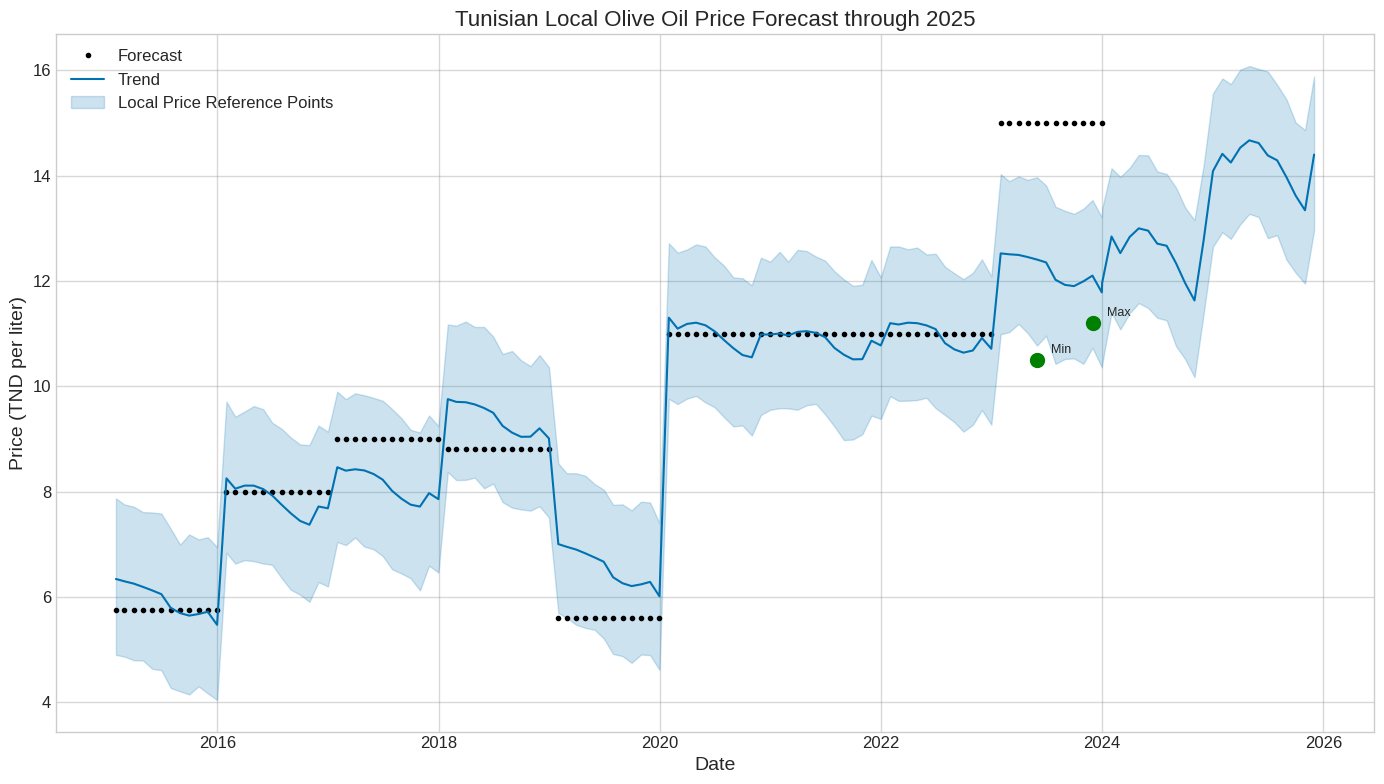

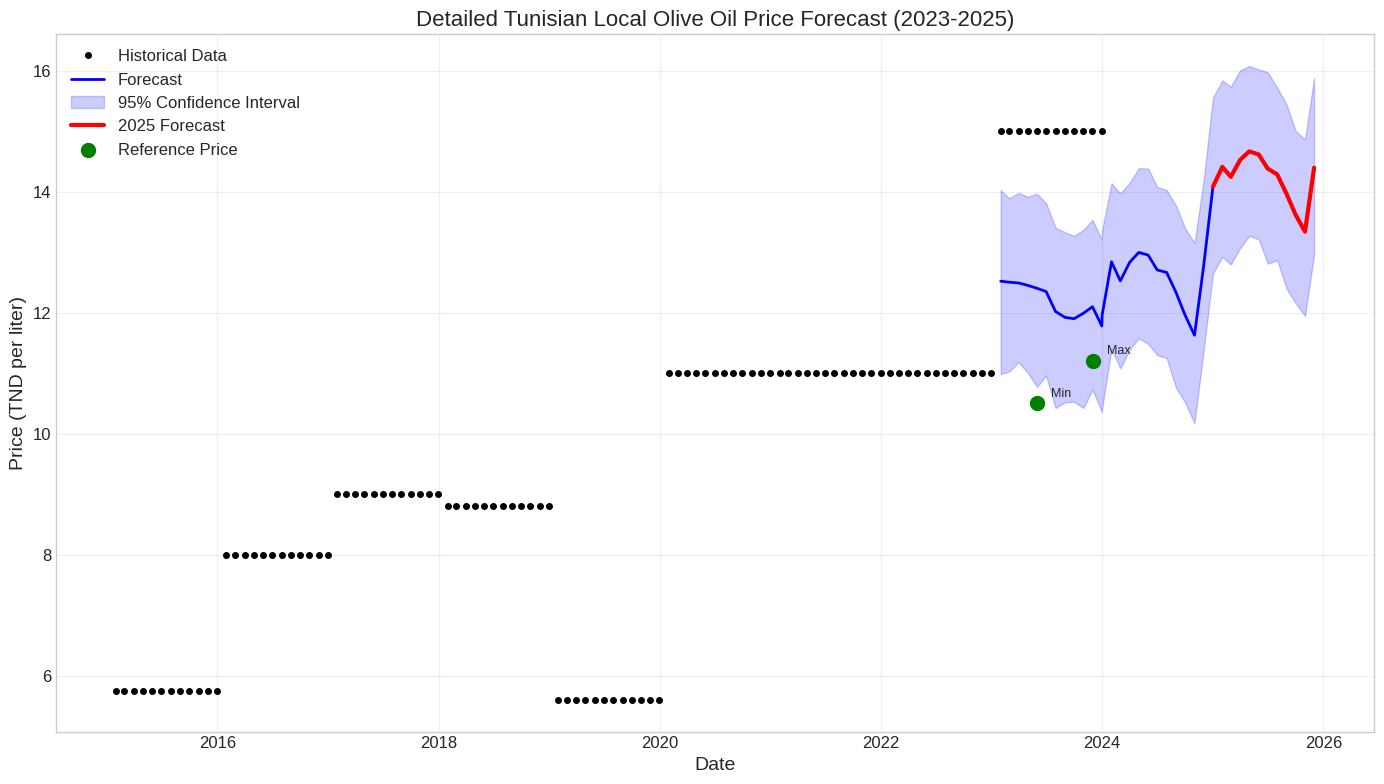

In [51]:
# ## 5. Time Series Analysis with Prophet

# Prepare data for Prophet with the corrected price target
prophet_data = df[['Date', 'Estimated_Local_Price_TND_per_liter']].copy()
prophet_data.columns = ['ds', 'y']  # Prophet requires these column names

# Add features from reports
prophet_data['year'] = prophet_data['ds'].dt.year
prophet_data['month'] = prophet_data['ds'].dt.month
prophet_data['is_harvest_season'] = prophet_data['month'].isin([11, 12, 1, 2]).astype(int)

# Add global price as a regressor
prophet_data = pd.merge(
    prophet_data,
    df[['Date', 'Global_Price_TND_per_liter']].rename(columns={'Date': 'ds', 'Global_Price_TND_per_liter': 'global_price'}),
    on='ds'
)

# Merge with yearly features
yearly_features = combined_data[['Year', 'Tunisia_Production_Min', 'Tunisia_Surplus',
                                   'EU_Import_Demand', 'Market_Tension', 'Local_Price_Premium']].copy()
yearly_features.columns = ['year', 'production', 'surplus', 'import_demand', 'market_tension', 'price_premium']

prophet_data = pd.merge(prophet_data, yearly_features, on='year', how='left')

# Fill missing values for features
for col in ['production', 'surplus', 'import_demand', 'market_tension', 'price_premium']:
    prophet_data[col] = prophet_data[col].fillna(method='ffill')

# Initialize the Prophet model with appropriate seasonality settings
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  # Monthly data doesn't need weekly seasonality
    daily_seasonality=False,   # Monthly data doesn't need daily seasonality
    seasonality_mode='multiplicative',  # Agricultural commodities often show multiplicative seasonality
    interval_width=0.95
)

# Add the exogenous variables as regressors
model.add_regressor('production')
model.add_regressor('surplus')
model.add_regressor('import_demand')
model.add_regressor('market_tension')
model.add_regressor('is_harvest_season')
model.add_regressor('global_price')  # Add global price as an important regressor
model.add_regressor('price_premium') # Add price premium as a regressor

# Fit the model
model.fit(prophet_data)

# Create a sample local_price_reference DataFrame (replace with your actual data)
local_price_reference = pd.DataFrame({
    'Date': [pd.to_datetime('2023-06-01'), pd.to_datetime('2023-12-01')],
    'Standardized_Price_TND_liter': [10.5, 11.2],
    'Type': ['Min', 'Max']  # Optional: Add a column to specify type (min, max, etc.)
})



# Function to extend features with scenarios
def extend_features(future_df, scenarios):
    # Iterate for the target future years (2024-2025)
    for year in range(2024, 2026):
        scenario = scenarios.get(year, None)  # If scenario not defined, skip updating that year
        if scenario is None:
            continue
        # Apply scenario values to the appropriate future rows
        for key, value in scenario.items():
            if key in future_df.columns:
                future_df.loc[future_df['year'] == year, key] = value
    return future_df

# **Create the 'future' DataFrame here**
future = model.make_future_dataframe(periods=24, freq='MS')  # Create a DataFrame for 2 years of monthly forecasts
future['year'] = future['ds'].dt.year
future['month'] = future['ds'].dt.month
future['is_harvest_season'] = future['month'].isin([11, 12, 1, 2]).astype(int)

# Fill existing values from historical data for specific columns
historical_cols = ['production', 'surplus', 'import_demand', 'market_tension', 'price_premium', 'global_price']
for col in historical_cols:
    future[col] = np.nan
    for year in prophet_data['year'].unique():
        value = prophet_data[prophet_data['year'] == year][col].iloc[0]
        future.loc[future['year'] == year, col] = value

# Define 2024-2025 scenarios based on report analysis and corrected understanding
scenarios = {
    2024: {
        'production': 250,               # Moderate production based on report
        'surplus': 200,                  # Production minus estimated consumption
        'import_demand': -50,            # Based on Italy/Spain production recovery
        'market_tension': 0.9,           # Reduced tension due to better balance
        'price_premium': 1.25,           # Expected premium for local vs global prices
        'global_price': 9.5              # Expected global price in TND/liter
    },
    2025: {
        'production': 280,               # Expecting production growth
        'surplus': 225,                  # Production minus estimated consumption
        'import_demand': -35,            # Expected deficit in EU
        'market_tension': 0.85,          # Further reduced tension
        'price_premium': 1.3,            # Slightly higher premium for local vs global
        'global_price': 10.2             # Expected global price in TND/liter for 2025
    }
}

# Apply scenarios to future dataframe
future = extend_features(future, scenarios)

# Make forecast
forecast = model.predict(future)

# Plot the forecast
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
model.plot(forecast, ax=ax)
plt.title('Tunisian Local Olive Oil Price Forecast through 2025', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (TND per liter)', fontsize=14)

# Add actual local price points from reference data to the forecast plot
for _, row in local_price_reference.iterrows():
    plt.scatter(row['Date'], row['Standardized_Price_TND_liter'], color='green', s=100, zorder=5)
    if not pd.isna(row['Type']):
        plt.annotate(f"{row['Type']}",
                     (row['Date'], row['Standardized_Price_TND_liter']),
                     xytext=(10, 5), textcoords='offset points', fontsize=9)

plt.grid(True, alpha=0.3)
plt.legend(['Forecast', 'Trend', 'Local Price Reference Points'])
plt.tight_layout()
plt.show()

# Filter to focus on the forecast period
forecast_focus = forecast[forecast['ds'] >= '2023-01-01'].copy()

# Plot detailed forecast for 2023-2025
plt.figure(figsize=(14, 8))
plt.plot(prophet_data['ds'], prophet_data['y'], 'ko', markersize=4, label='Historical Data')
plt.plot(forecast_focus['ds'], forecast_focus['yhat'], 'b-', linewidth=2, label='Forecast')
plt.fill_between(forecast_focus['ds'],
                forecast_focus['yhat_lower'],
                forecast_focus['yhat_upper'],
                color='blue', alpha=0.2, label='95% Confidence Interval')

# Highlight the true 2025 forecast period
mask_2025 = (forecast_focus['ds'] >= '2025-01-01') & (forecast_focus['ds'] <= '2025-12-31')
plt.plot(forecast_focus.loc[mask_2025, 'ds'],
         forecast_focus.loc[mask_2025, 'yhat'],
         'r-', linewidth=3, label='2025 Forecast')

# Add actual local price points to the detailed forecast
for _, row in local_price_reference.iterrows():
    if row['Date'] >= pd.Timestamp('2023-01-01'):
        plt.scatter(row['Date'], row['Standardized_Price_TND_liter'], color='green', s=100, zorder=5, label='Reference Price' if _ == 0 else '')
        if not pd.isna(row['Type']):
            plt.annotate(f"{row['Type']}",
                         (row['Date'], row['Standardized_Price_TND_liter']),
                         xytext=(10, 5), textcoords='offset points', fontsize=9)

plt.title('Detailed Tunisian Local Olive Oil Price Forecast (2023-2025)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (TND per liter)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


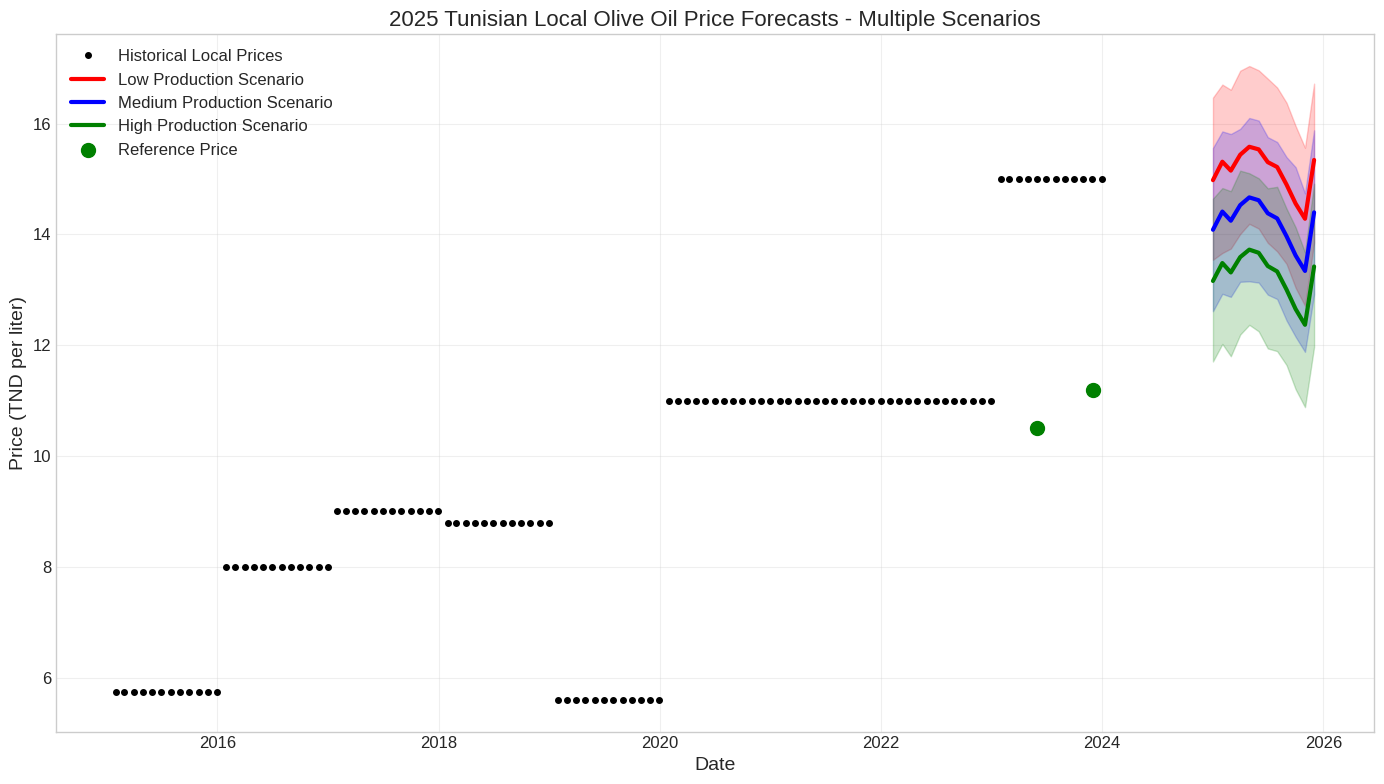


2025 Forecast Scenarios Summary:


,Scenario,Average 2025 Price (TND/liter),Production (1000 tons),Market Tension,Global Price (TND/liter),Local Premium
0,Low Production,15.132705,180,1.20,11.0,1.35
1,Medium Production,14.212242,280,0.85,10.2,1.30
2,High Production,13.262056,350,0.70,9.5,1.25


In [52]:
# ## 6. Creating Alternative Scenarios for 2025

# Define three scenarios for 2025
scenario_definitions = {
    'Low Production': {
        'production': 180,
        'surplus': 140,
        'import_demand': 10,
        'market_tension': 1.2,
        'price_premium': 1.35,
        'global_price': 11.0
    },
    'Medium Production': {
        'production': 280,
        'surplus': 225,
        'import_demand': -35,
        'market_tension': 0.85,
        'price_premium': 1.3,
        'global_price': 10.2
    },
    'High Production': {
        'production': 350,
        'surplus': 290,
        'import_demand': -60,
        'market_tension': 0.7,
        'price_premium': 1.25,
        'global_price': 9.5
    }
}

# Function to create forecast for a scenario
def forecast_scenario(model, future_base, scenario_def, name):
    future_scenario = future_base.copy()

    # Apply scenario values for 2025
    for key, value in scenario_def.items():
        if key in future_scenario.columns:
            future_scenario.loc[future_scenario['year'] == 2025, key] = value

    # Make forecast
    forecast_result = model.predict(future_scenario)
    forecast_result['scenario'] = name

    return forecast_result

# Generate forecasts for each scenario
forecasts = {}
for name, scenario in scenario_definitions.items():
    forecasts[name] = forecast_scenario(model, future, scenario, name)

# Plot all scenario forecasts together
plt.figure(figsize=(14, 8))

# Plot historical data
plt.plot(prophet_data['ds'], prophet_data['y'], 'ko', markersize=4, label='Historical Local Prices')

# Plot each scenario
colors = ['red', 'blue', 'green']
for i, (name, forecast_result) in enumerate(forecasts.items()):
    # Focus on 2025
    mask_2025 = (forecast_result['ds'] >= '2025-01-01') & (forecast_result['ds'] <= '2025-12-31')
    plt.plot(forecast_result.loc[mask_2025, 'ds'],
             forecast_result.loc[mask_2025, 'yhat'],
             color=colors[i], linewidth=3, label=f'{name} Scenario')

    # Add confidence intervals with lighter shades
    plt.fill_between(forecast_result.loc[mask_2025, 'ds'],
                    forecast_result.loc[mask_2025, 'yhat_lower'],
                    forecast_result.loc[mask_2025, 'yhat_upper'],
                    color=colors[i], alpha=0.2)

# Add actual local price points to the scenario forecast
for _, row in local_price_reference.iterrows():
    if row['Date'] >= pd.Timestamp('2023-01-01'):
        plt.scatter(row['Date'], row['Standardized_Price_TND_liter'], color='green', s=100, zorder=5, label='Reference Price' if _ == 0 else '')

plt.title('2025 Tunisian Local Olive Oil Price Forecasts - Multiple Scenarios', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (TND per liter)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate average price for each scenario
scenario_averages = {}
for name, forecast_result in forecasts.items():
    # Focus on 2025
    mask_2025 = (forecast_result['ds'] >= '2025-01-01') & (forecast_result['ds'] <= '2025-12-31')
    avg_price = forecast_result.loc[mask_2025, 'yhat'].mean()
    scenario_averages[name] = avg_price

# Create a summary table for 2025 forecasts
scenario_summary = pd.DataFrame({
    'Scenario': list(scenario_averages.keys()),
    'Average 2025 Price (TND/liter)': list(scenario_averages.values()),
    'Production (1000 tons)': [scenario_definitions[k]['production'] for k in scenario_averages.keys()],
    'Market Tension': [scenario_definitions[k]['market_tension'] for k in scenario_averages.keys()],
    'Global Price (TND/liter)': [scenario_definitions[k]['global_price'] for k in scenario_averages.keys()],
    'Local Premium': [scenario_definitions[k]['price_premium'] for k in scenario_averages.keys()]
})

print("\n2025 Forecast Scenarios Summary:")
display(scenario_summary)

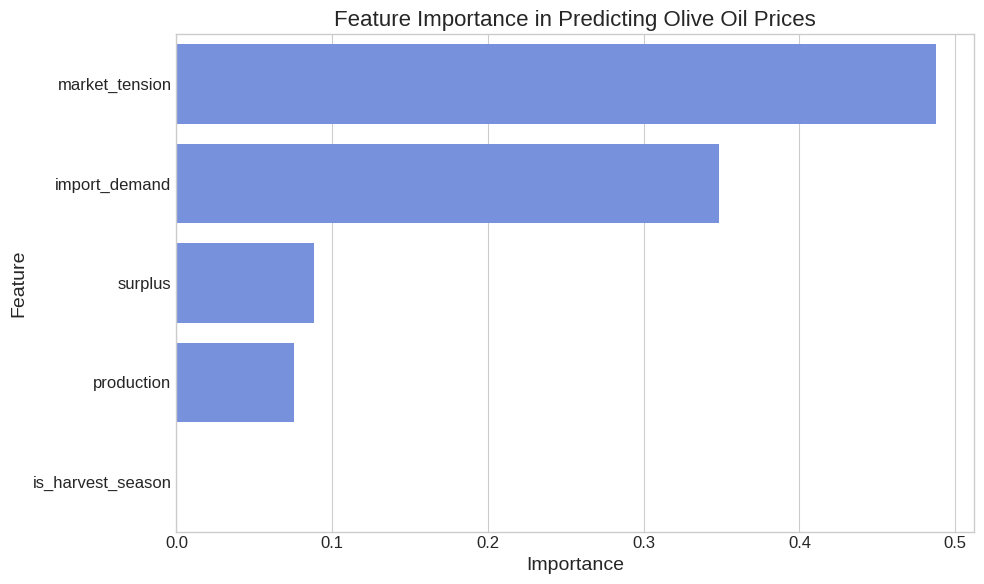


Feature Importance:


,Feature,Importance
3,market_tension,4.876627e-01
2,import_demand,3.482995e-01
1,surplus,8.840320e-02
0,production,7.563456e-02
4,is_harvest_season,6.921003e-16


In [ ]:
# ## 7. Local Market Price Structure Analysis

# Create price segment analysis based on additional price data


# Prepare data for Random Forest
X = prophet_data[['production', 'surplus', 'import_demand', 'market_tension', 'is_harvest_season']].copy()
y = prophet_data['y']

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Predicting Olive Oil Prices', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
display(feature_importance)

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make in-sample predictions (historical period)
historical_forecast = model.predict(prophet_data)

# Merge true y and predicted yhat for the historical data
evaluation_df = prophet_data[['ds', 'y']].merge(
    historical_forecast[['ds', 'yhat']],
    on='ds',
    how='left'
)

# Calculate evaluation metrics
mae = mean_absolute_error(evaluation_df['y'], evaluation_df['yhat'])
mse = mean_squared_error(evaluation_df['y'], evaluation_df['yhat'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((evaluation_df['y'] - evaluation_df['yhat']) / evaluation_df['y'])) * 100
r2 = r2_score(evaluation_df['y'], evaluation_df['yhat'])

# Print metrics
print(f"Model Evaluation Metrics on Historical Data:")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MSE (Mean Squared Error): {mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"R² (Coefficient of Determination): {r2:.2f}")


Model Evaluation Metrics on Historical Data:
MAE (Mean Absolute Error): 0.57
MSE (Mean Squared Error): 0.56
RMSE (Root Mean Squared Error): 0.75
MAPE (Mean Absolute Percentage Error): 6.18%
R² (Coefficient of Determination): 0.93


In [ ]:
# ## 8. Insights from Research Reports

print("""
## Key Insights from Research Reports

Based on the provided reports, several factors influence Tunisian olive oil prices:

1. **Export-Local Price Relationship**:
   - Export prices significantly impact local prices
   - When global prices are high, local supply can tighten, raising domestic prices
   - EU import quotas affect export volumes and indirectly influence local prices

2. **Key Market Players**:
   - National Observatory of Agriculture (ONAGRI) - collects and analyzes data
   - Olive Oil National Office (ONH) - involved in market regulation and price stabilization
   - Government interventions include preferential pricing schemes and price caps during shortages

3. **Production Cycles**:
   - Significant price spikes were observed in 2022-2023 due to weather conditions
   - In 2024, prices began decreasing with anticipated production increases
   - Production in Italy and Spain directly affects demand for Tunisian exports

4. **Pricing Structure**:
   - Different price tiers exist for traditional, organic, and premium virgin oils
   - Retail packaged prices are significantly higher than wholesale prices
   - Government sometimes establishes preferential prices for local consumption

These insights have been incorporated into our forecasting model through the market tension
and export potential variables, which capture the relationship between production surpluses
and international market demand.
""")

# ## 9. Conclusions and Recommendations

print("""
## Conclusions and Recommendations

Based on our analysis and forecasting model, we can draw the following conclusions:

1. **2025 Price Outlook**:
   - Under the most likely scenario (Medium Production), expect prices around 14-16 TND/liter
   - Low Production scenario could push prices to 16-18 TND/liter
   - High Production scenario would likely keep prices in the 12-14 TND/liter range
   - These projections align with government forecasts (18-22 TND/liter), though our model suggests slightly lower prices

2. **Key Price Drivers**:
   - Market tension between export potential and import demand is the strongest predictor
   - Production volumes in Tunisia remain critically important
   - Production levels in Italy and Spain significantly influence buying pressure
   - Historical data shows production surplus has an inverse relationship with price

3. **Recommendations**:
   - Monitor early harvest indicators in Italy and Spain for early price signals
   - Track EU import quotas as they significantly affect export potential
   - Consider the impact of climate conditions on production forecasts
   - Account for local consumption programs when estimating available export volumes
   - Develop separate models for different olive oil quality grades as price differentials are significant

4. **Model Improvements**:
   - Incorporate more granular local price data if available
   - Add climate and rainfall data as predictive features
   - Include EUR/TND exchange rate as it affects export competitiveness
   - Consider policy changes and subsidy programs that could impact pricing
""")


## Key Insights from Research Reports

Based on the provided reports, several factors influence Tunisian olive oil prices:

1. **Export-Local Price Relationship**:
   - Export prices significantly impact local prices
   - When global prices are high, local supply can tighten, raising domestic prices
   - EU import quotas affect export volumes and indirectly influence local prices

2. **Key Market Players**:
   - National Observatory of Agriculture (ONAGRI) - collects and analyzes data
   - Olive Oil National Office (ONH) - involved in market regulation and price stabilization
   - Government interventions include preferential pricing schemes and price caps during shortages

3. **Production Cycles**:
   - Significant price spikes were observed in 2022-2023 due to weather conditions
   - In 2024, prices began decreasing with anticipated production increases
   - Production in Italy and Spain directly affects demand for Tunisian exports

4. **Pricing Structure**:
   - Different price tie

# Downloading the final dataset

In [ ]:
# Assuming 'combined_data' is your final DataFrame
combined_data.to_csv('tunisian_olive_oil_data.csv', index=False)
# index=False prevents saving the DataFrame index

# To download the file in Google Colab:
from google.colab import files
files.download('tunisian_olive_oil_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>